In [2]:
import pandas as pd

In [5]:
!pip install sentence-transformers transformers datasets scikit-learn

In [13]:
!pip install -q sentence-transformers scikit-learn torch

In [14]:
import os
os.environ["WANDB_DISABLED"] = "true"  # ✅ disables Weights & Biases login

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses, util
import matplotlib.pyplot as plt


In [15]:
df = pd.read_csv("train.csv")

# ✅ Use a smaller subset for much faster training
df = df.sample(10000, random_state=42)

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
dev_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_df.to_csv("quora_train.csv", index=False)
dev_df.to_csv("quora_dev.csv", index=False)
test_df.to_csv("quora_test.csv", index=False)

print(f"✅ Saved splits: Train={len(train_df)}, Dev={len(dev_df)}, Test={len(test_df)}")

✅ Saved splits: Train=8000, Dev=1000, Test=1000


In [16]:
def evaluate_model(model, test_df):
    batch_size = 32
    q1_emb = model.encode(test_df['question1'].tolist(), batch_size=batch_size, convert_to_tensor=True)
    q2_emb = model.encode(test_df['question2'].tolist(), batch_size=batch_size, convert_to_tensor=True)
    cosine_scores = util.cos_sim(q1_emb, q2_emb)
    y_true = test_df['is_duplicate'].tolist()
    y_pred = [1 if score > 0.5 else 0 for score in cosine_scores.diag()]
    return f1_score(y_true, y_pred)

In [17]:
train_samples = [InputExample(texts=[row['question1'], row['question2']], label=float(row['is_duplicate'])) for _, row in train_df.iterrows()]


In [18]:
def train_bi_encoder(model_name, loss_fn, epochs=1):
    model = SentenceTransformer(model_name)
    train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=32)
    model.fit(train_objectives=[(train_dataloader, loss_fn)], epochs=epochs, show_progress_bar=True)
    return model

bi_encoder_results = {}

In [19]:
# 1. Bi-Encoder with CosineSimilarityLoss
model_cs = train_bi_encoder('all-MiniLM-L6-v2', losses.CosineSimilarityLoss(SentenceTransformer('all-MiniLM-L6-v2')))
f1_cs = evaluate_model(model_cs, test_df)
bi_encoder_results["CosineSimilarityLoss"] = f1_cs

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


In [20]:
# 2. Bi-Encoder with ContrastiveLoss
model_cl = train_bi_encoder('all-MiniLM-L6-v2', losses.ContrastiveLoss(SentenceTransformer('all-MiniLM-L6-v2')))
f1_cl = evaluate_model(model_cl, test_df)
bi_encoder_results["ContrastiveLoss"] = f1_cl

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


Step,Training Loss


In [22]:
# 3. Bi-Encoder with MultipleNegativesRankingLoss
model_mn = train_bi_encoder('all-MiniLM-L6-v2', losses.MultipleNegativesRankingLoss(SentenceTransformer('all-MiniLM-L6-v2')))
f1_mn = evaluate_model(model_mn, test_df)
bi_encoder_results["MultipleNegativesRankingLoss"] = f1_mn

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss



📊 F1-SCORE RESULTS
CosineSimilarityLoss: 0.6631
ContrastiveLoss: 0.6562
MultipleNegativesRankingLoss: 0.6580


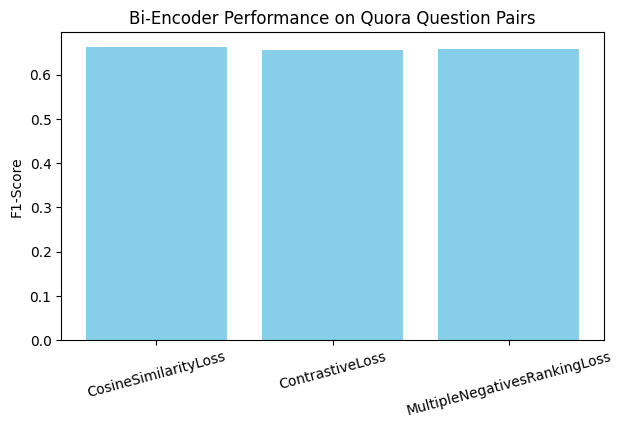

In [23]:
print("\n📊 F1-SCORE RESULTS")
for model_name, score in bi_encoder_results.items():
    print(f"{model_name}: {score:.4f}")

plt.figure(figsize=(7,4))
plt.bar(bi_encoder_results.keys(), bi_encoder_results.values(), color='skyblue')
plt.ylabel("F1-Score")
plt.title("Bi-Encoder Performance on Quora Question Pairs")
plt.xticks(rotation=15)
plt.show()